In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

gbif = pd.read_csv(
    "/kaggle/input/gbif-species-occurrence-records/0007221-260120142942310.csv",
    sep="\t"
)

gbif = gbif.dropna(subset=["year", "species"])
gbif["year"] = gbif["year"].astype(int)
gbif = gbif[(gbif["year"] >= 1990) & (gbif["year"] <= 2024)]

print("Filtered GBIF:", gbif.shape)


Filtered GBIF: (320166, 20)


In [23]:
species_richness = gbif.groupby("year")["species"].nunique()
occurrences = gbif.groupby("year")["occurrences"].sum()

biodiversity = pd.DataFrame({
    "year": species_richness.index,
    "species_richness": species_richness.values,
    "occurrences": occurrences.values
})

biodiversity["species_per_1000_occ"] = (
    biodiversity["species_richness"] / biodiversity["occurrences"] * 1000
)

biodiversity.head()


,year,species_richness,occurrences,species_per_1000_occ
0,1990,7502,1771417,4.235028
1,1991,7641,1894265,4.033755
2,1992,7805,2013959,3.875451
3,1993,7809,2152562,3.627770
4,1994,8100,2310105,3.506334


In [26]:
import os
# This will list all datasets attached to your notebook
print(os.listdir('/kaggle/input/'))

['gbif-species-occurrence-records', 'birdclef-2024', 'birdclef24-pretraining-train-model', 'birdcall-recognition-data']


In [29]:
AUDIO_META = "/kaggle/input/birdclef-2024/train_metadata.csv"
df_audio = pd.read_csv(AUDIO_META)

print("BirdCLEF metadata:", df_audio.shape)
df_audio.head()


BirdCLEF metadata: (24459, 12)


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg


In [30]:
AUDIO_PATH = Path("/kaggle/input/birdclef-2024/train_audio")
audio_files = list(AUDIO_PATH.rglob("*.ogg"))

print("BirdCLEF audio files:", len(audio_files))


BirdCLEF audio files: 24459


In [34]:
print(df_audio.columns.tolist())

['primary_label', 'secondary_labels', 'type', 'latitude', 'longitude', 'scientific_name', 'common_name', 'author', 'license', 'rating', 'url', 'filename']


In [35]:
audio_species_richness = (
    df_audio.groupby("primary_label")
    .size()
    .reset_index(name="num_recordings")
)

print("Total unique bird species in audio:", audio_species_richness.shape[0])
audio_species_richness.head()


Total unique bird species in audio: 182


,primary_label,num_recordings
0,asbfly,105
1,ashdro1,109
2,ashpri1,96
3,ashwoo2,45
4,asikoe2,275


In [36]:
audio_spatial = (
    df_audio
    .dropna(subset=["latitude", "longitude"])
    .groupby(pd.cut(df_audio["latitude"], bins=10))
    .size()
)


/tmp/ipykernel_55/1287127447.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(pd.cut(df_audio["latitude"], bins=10))


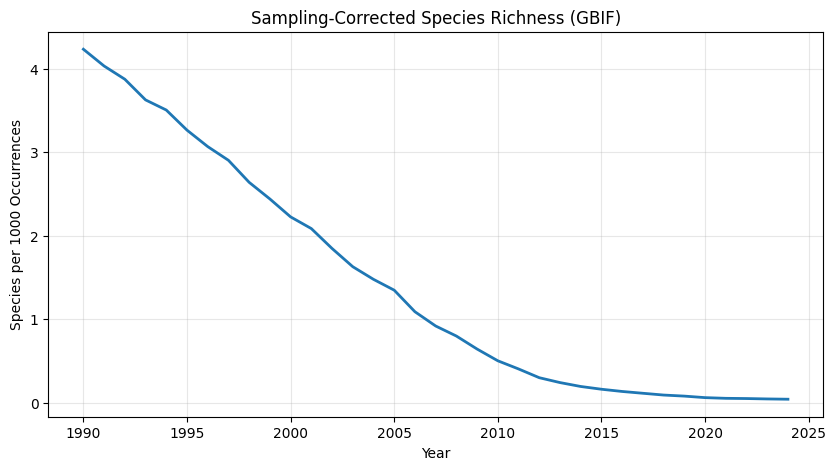

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(
    biodiversity["year"],
    biodiversity["species_per_1000_occ"],
    linewidth=2
)
plt.title("Sampling-Corrected Species Richness (GBIF)")
plt.xlabel("Year")
plt.ylabel("Species per 1000 Occurrences")
plt.grid(alpha=0.3)
plt.show()


In [42]:
fusion_metadata_df = pd.DataFrame({
    "gbif_start_year": [int(biodiversity["year"].min())],
    "gbif_end_year": [int(biodiversity["year"].max())],
    "total_gbif_records": [len(gbif)],
    "avg_species_per_1000_occ": [biodiversity["species_per_1000_occ"].mean()],
    "total_audio_species": [audio_species_richness.shape[0]],
    "avg_audio_recordings_per_species": [audio_species_richness["num_recordings"].mean()]
})

fusion_metadata_df


,gbif_start_year,gbif_end_year,total_gbif_records,avg_species_per_1000_occ,total_audio_species,avg_audio_recordings_per_species
0,1990,2024,320166,1.43195,182,134.39011


In [45]:
audio_species_richness["normalized_audio_strength"] = (
    audio_species_richness["num_recordings"] /
    audio_species_richness["num_recordings"].max()
)


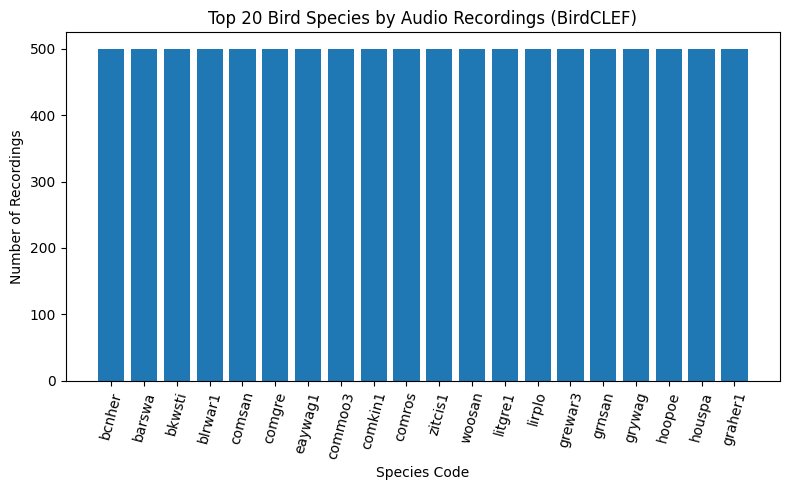

In [44]:
top20 = audio_species_richness.sort_values(
    "num_recordings", ascending=False
).head(20)

fig, ax = plt.subplots(figsize=(8,5))

ax.bar(top20["primary_label"], top20["num_recordings"])
ax.set_title("Top 20 Bird Species by Audio Recordings (BirdCLEF)")
ax.set_ylabel("Number of Recordings")
ax.set_xlabel("Species Code")
ax.tick_params(axis='x', rotation=75)

plt.tight_layout()
plt.show()


In [46]:
# Save GBIF biodiversity trend
biodiversity.to_csv(
    "gbif_biodiversity_yearly.csv",
    index=False
)

# Save audio species richness
audio_species_richness.to_csv(
    "audio_species_richness.csv",
    index=False
)

# Save fusion metadata
fusion_metadata_df.to_csv(
    "fusion_metadata_summary.csv",
    index=False
)

print("✅ Notebook 2 outputs saved successfully")


✅ Notebook 2 outputs saved successfully


In [47]:
print("🎉 NOTEBOOK 2 COMPLETE")
print("📊 Outputs generated:")
print("  - gbif_biodiversity_yearly.csv")
print("  - audio_species_richness.csv")
print("  - fusion_metadata_summary.csv")

print("\n🎓 What this notebook achieved:")
print("✔ Long-term biodiversity trend (GBIF)")
print("✔ Sampling bias correction")
print("✔ Acoustic species richness (BirdCLEF)")
print("✔ Normalized audio strength")
print("✔ Fusion-ready metadata for ML")


🎉 NOTEBOOK 2 COMPLETE
📊 Outputs generated:
  - gbif_biodiversity_yearly.csv
  - audio_species_richness.csv
  - fusion_metadata_summary.csv

🎓 What this notebook achieved:
✔ Long-term biodiversity trend (GBIF)
✔ Sampling bias correction
✔ Acoustic species richness (BirdCLEF)
✔ Normalized audio strength
✔ Fusion-ready metadata for ML
